In [11]:
# Setup and imports
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Setup paths
repo_root = Path.cwd()
for up in [repo_root, repo_root.parent, repo_root.parent.parent]:
    if (up / "src").exists():
        repo_root = up
        break
sys.path.insert(0, str(repo_root))

# Import your EKF model
from src.ekf_model import CoordinatedTurnEKF, EKFParams

print(f"✓ Repository root: {repo_root}")
print(f"✓ EKF model imported successfully")

✓ Repository root: /Users/danielvillafuerte/weather-aware-trajectory-prediction
✓ EKF model imported successfully


In [12]:
# Load the processed data
DATA_PATH = repo_root / "data" / "processed" / "flights_nativecadence_enu_kinematics.parquet"
df = pd.read_parquet(DATA_PATH)

print(f"✓ Loaded {len(df):,} rows")
print(f"✓ Number of flights: {df['flight_id'].nunique()}")
print(f"✓ Columns: {list(df.columns)}\n")

# Find good flights for analysis (sufficient length and distance)
flight_stats = df.groupby(['flight_id', 'run_id']).agg({
    'time': 'count',
    'E': lambda x: x.max() - x.min(),
    'N': lambda x: x.max() - x.min()
}).rename(columns={'time': 'n_points', 'E': 'E_range', 'N': 'N_range'})

flight_stats['distance'] = np.sqrt(flight_stats['E_range']**2 + flight_stats['N_range']**2)

# Filter for good examples
good_flights = flight_stats[(flight_stats['n_points'] > 200) & 
                            (flight_stats['distance'] > 50000)].head(10)

print("Good example flights for visualization:")
print(good_flights[['n_points', 'distance']].sort_values('distance', ascending=False))

✓ Loaded 1,038,555 rows
✓ Number of flights: 5335
✓ Columns: ['time', 'icao24', 'lat', 'lon', 'alt', 'callsign', 'velocity', 'heading', 'vertrate', 'gap_s', 'flight_id', 'dt', 'run_id', 'E', 'N', 'U', 'dE', 'dN', 'dU', 'vE', 'vN', 'vU', 'speed', 'heading_rad', 'heading_unwrapped', 'turn_rate']

Good example flights for visualization:
                  n_points       distance
flight_id run_id                         
16        0            325  747314.425298
10        0            326  736467.268438
21        0            325  680498.536783
27        0            293  627474.886181
18        0            276  611889.548352
13        0            216  505777.929713
4         0            218  486413.308828
7         0            287  476139.839128
20        0            265  446364.264714
15        0            359  329508.288748


In [13]:
class EKFTrajectoryVisualizer:
    """Comprehensive EKF trajectory prediction visualizer"""
    
    def __init__(self, ekf_params=None):
        params = ekf_params if ekf_params else EKFParams()
        self.ekf = CoordinatedTurnEKF(params=params, use_wind=False)
        self.horizons = [60, 120, 300]
        self.colors = {60: '#FFA500', 120: '#FF4444', 300: '#9400D3'}
        
    def prepare_flight_data(self, df, flight_id, run_id):
        """Extract and prepare a specific flight"""
        flight = df[(df['flight_id'] == flight_id) & (df['run_id'] == run_id)].copy()
        flight = flight.sort_values('time').reset_index(drop=True)
        
        # Add missing columns if needed
        if 'turn_rate' not in flight.columns:
            flight['turn_rate'] = 0.0
            
        return flight
    
    def run_ekf_prediction(self, flight, pred_idx):
        """Run EKF filter and make predictions"""
        
        # Filter up to prediction point
        filtered = self.ekf.filter_track(flight.iloc[:pred_idx+1])
        
        # Get state at prediction point
        last_state = filtered.iloc[-1]
        x = np.array([
            last_state.E_hat, last_state.N_hat, last_state.U_hat,
            last_state.vE_hat, last_state.vN_hat, last_state.vU_hat,
            last_state.omega_hat
        ])
        
        # Make predictions
        predictions = {}
        errors = {}
        t_start = flight.iloc[pred_idx]['time']
        
        for h in self.horizons:
            # Predict
            x_pred = self.ekf.forecast_state(x, h)
            predictions[h] = x_pred[:3]  # E, N, U
            
            # Find actual position
            target_time = t_start + pd.Timedelta(seconds=h)
            future = flight[flight['time'] >= target_time]
            
            if len(future) > 0:
                actual = future.iloc[0][['E', 'N', 'U']].values
                error = np.linalg.norm(predictions[h] - actual)
                errors[h] = {
                    'predicted': predictions[h],
                    'actual': actual,
                    'error_m': error
                }
        
        return filtered, predictions, errors

# Create visualizer instance
viz = EKFTrajectoryVisualizer()
print("✓ EKF Visualizer created")

✓ EKF Visualizer created


In [14]:
def plot_3d_trajectory(flight, filtered, predictions, errors, pred_idx):
    """Create detailed 3D trajectory visualization"""
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Historical track (before prediction)
    hist = flight.iloc[:pred_idx+1]
    ax.plot(hist['E'], hist['N'], hist['U'], 
            'gray', linewidth=3, alpha=0.7, label='Historical Track')
    
    # Actual future path
    future = flight.iloc[pred_idx:]
    ax.plot(future['E'], future['N'], future['U'],
            'g-', linewidth=4, alpha=0.8, label='Actual Path')
    
    # Filtered track
    ax.plot(filtered['E_hat'], filtered['N_hat'], filtered['U_hat'],
            'b--', linewidth=2, alpha=0.6, label='EKF Filtered')
    
    # Prediction start point
    start = flight.iloc[pred_idx]
    ax.scatter(start['E'], start['N'], start['U'],
               c='blue', s=200, marker='o', edgecolors='black',
               linewidth=2, label='Prediction Start', zorder=5)
    
    # Predictions and errors
    for h in viz.horizons:
        if h in errors:
            pred = errors[h]['predicted']
            actual = errors[h]['actual']
            color = viz.colors[h]
            
            # Prediction line from start
            ax.plot([start['E'], pred[0]], 
                   [start['N'], pred[1]], 
                   [start['U'], pred[2]],
                   color=color, linewidth=3, linestyle='--',
                   label=f'{h}s Pred ({errors[h]["error_m"]:.0f}m error)')
            
            # Predicted point
            ax.scatter(pred[0], pred[1], pred[2],
                      c=color, s=150, marker='^', edgecolors='black', linewidth=1)
            
            # Actual point
            ax.scatter(actual[0], actual[1], actual[2],
                      c=color, s=150, marker='s', alpha=0.5, edgecolors='black')
            
            # Error line
            ax.plot([pred[0], actual[0]], 
                   [pred[1], actual[1]], 
                   [pred[2], actual[2]],
                   color=color, linewidth=1.5, linestyle=':', alpha=0.7)
    
    # Labels and formatting
    ax.set_xlabel('East (m)', fontsize=12, labelpad=10)
    ax.set_ylabel('North (m)', fontsize=12, labelpad=10)
    ax.set_zlabel('Altitude (m)', fontsize=12, labelpad=10)
    ax.set_title(f'3D Trajectory: EKF Predictions vs Actual Path\nFlight {flight.iloc[0]["flight_id"]}, Run {flight.iloc[0]["run_id"]}',
                 fontsize=14, fontweight='bold', pad=20)
    
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    # Set better viewing angle
    ax.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    return fig

In [15]:
def create_comprehensive_plot(flight, filtered, predictions, errors, pred_idx):
    """Create multi-panel comprehensive visualization"""
    
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3,
                  width_ratios=[1.5, 1, 1], height_ratios=[1.2, 1, 1])
    
    # --- 3D Trajectory (main view) ---
    ax3d = fig.add_subplot(gs[:, 0], projection='3d')
    
    hist = flight.iloc[:pred_idx+1]
    future = flight.iloc[pred_idx:]
    start = flight.iloc[pred_idx]
    
    ax3d.plot(hist['E'], hist['N'], hist['U'], 'gray', lw=3, alpha=0.6, label='Historical')
    ax3d.plot(future['E'], future['N'], future['U'], 'g-', lw=3, alpha=0.8, label='Actual')
    ax3d.scatter(start['E'], start['N'], start['U'], c='blue', s=100, marker='o')
    
    for h in viz.horizons:
        if h in errors:
            pred = errors[h]['predicted']
            ax3d.plot([start['E'], pred[0]], [start['N'], pred[1]], [start['U'], pred[2]],
                     color=viz.colors[h], lw=2, ls='--', label=f'{h}s')
    
    ax3d.set_xlabel('East (m)')
    ax3d.set_ylabel('North (m)')
    ax3d.set_zlabel('Altitude (m)')
    ax3d.set_title('3D Trajectory', fontsize=12, fontweight='bold')
    ax3d.legend(loc='upper left', fontsize=8)
    ax3d.view_init(elev=20, azim=45)
    
    # --- Top View (E-N plane) ---
    ax_top = fig.add_subplot(gs[0, 1])
    ax_top.plot(hist['E'], hist['N'], 'gray', lw=2, alpha=0.6)
    ax_top.plot(future['E'], future['N'], 'g-', lw=2, alpha=0.8)
    ax_top.scatter(start['E'], start['N'], c='blue', s=80, marker='o', zorder=5)
    
    for h in viz.horizons:
        if h in errors:
            pred = errors[h]['predicted']
            actual = errors[h]['actual']
            ax_top.arrow(start['E'], start['N'], 
                        pred[0]-start['E'], pred[1]-start['N'],
                        head_width=2000, head_length=3000, 
                        fc=viz.colors[h], ec=viz.colors[h], alpha=0.6)
            ax_top.scatter(actual[0], actual[1], c=viz.colors[h], s=60, marker='s', alpha=0.5)
    
    ax_top.set_xlabel('East (m)')
    ax_top.set_ylabel('North (m)')
    ax_top.set_title('Top View (Horizontal)', fontsize=10, fontweight='bold')
    ax_top.grid(True, alpha=0.3)
    ax_top.axis('equal')
    
    # --- Side View (Distance-Altitude) ---
    ax_side = fig.add_subplot(gs[0, 2])
    
    # Calculate cumulative distance
    dist_hist = np.sqrt(np.diff(hist['E'])**2 + np.diff(hist['N'])**2)
    dist_hist = np.concatenate([[0], np.cumsum(dist_hist)])
    dist_future = np.sqrt(np.diff(flight['E'])**2 + np.diff(flight['N'])**2)
    dist_future = np.concatenate([[0], np.cumsum(dist_future)])
    
    ax_side.plot(dist_hist, hist['U'], 'gray', lw=2, alpha=0.6)
    ax_side.plot(dist_future[pred_idx:], future['U'], 'g-', lw=2, alpha=0.8)
    ax_side.scatter(dist_future[pred_idx], start['U'], c='blue', s=80, marker='o', zorder=5)
    
    ax_side.set_xlabel('Distance (m)')
    ax_side.set_ylabel('Altitude (m)')
    ax_side.set_title('Altitude Profile', fontsize=10, fontweight='bold')
    ax_side.grid(True, alpha=0.3)
    
    # --- Time Series ---
    ax_time = fig.add_subplot(gs[1, 1:])
    
    time_sec = (flight['time'] - flight['time'].iloc[0]).dt.total_seconds()
    pred_time = time_sec.iloc[pred_idx]
    
    ax_time.plot(time_sec, flight['U'], 'g-', lw=2, alpha=0.8, label='Actual Altitude')
    ax_time.axvline(pred_time, color='blue', ls='--', alpha=0.5, label='Prediction Time')
    
    for h in viz.horizons:
        if h in errors:
            ax_time.scatter(pred_time + h, errors[h]['predicted'][2],
                          c=viz.colors[h], s=80, marker='^', label=f'{h}s Pred', zorder=5)
            ax_time.scatter(pred_time + h, errors[h]['actual'][2],
                          c=viz.colors[h], s=80, marker='s', alpha=0.5, zorder=4)
    
    ax_time.set_xlabel('Time (seconds)')
    ax_time.set_ylabel('Altitude (m)')
    ax_time.set_title('Altitude Over Time', fontsize=10, fontweight='bold')
    ax_time.legend(loc='best', fontsize=8)
    ax_time.grid(True, alpha=0.3)
    
    # --- Error Analysis ---
    ax_error = fig.add_subplot(gs[2, 1:])
    
    if errors:
        horizons = list(errors.keys())
        error_values = [errors[h]['error_m'] for h in horizons]
        colors = [viz.colors[h] for h in horizons]
        
        bars = ax_error.bar(range(len(horizons)), error_values, color=colors, alpha=0.7)
        ax_error.set_xticks(range(len(horizons)))
        ax_error.set_xticklabels([f'{h}s' for h in horizons])
        ax_error.set_ylabel('Prediction Error (m)')
        ax_error.set_title('Prediction Errors (Attributed to Wind)', fontsize=10, fontweight='bold')
        ax_error.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, val in zip(bars, error_values):
            ax_error.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                        f'{val:.0f}m', ha='center', va='bottom', fontweight='bold')
    
    flight_id = flight.iloc[0]['flight_id']
    fig.suptitle(f'EKF Trajectory Prediction Analysis - Flight {flight_id}',
                fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig

In [16]:
def analyze_flight(df, flight_id, run_id, pred_ratio=0.33):
    """
    Complete analysis pipeline for a specific flight
    
    Args:
        df: DataFrame with all flight data
        flight_id: ID of flight to analyze
        run_id: Run ID within the flight
        pred_ratio: Where to start prediction (0.33 = 1/3 through flight)
    """
    
    print(f"\n{'='*60}")
    print(f"ANALYZING FLIGHT {flight_id}, RUN {run_id}")
    print(f"{'='*60}")
    
    # Prepare flight data
    flight = viz.prepare_flight_data(df, flight_id, run_id)
    print(f"Flight duration: {len(flight)} points")
    
    # Calculate flight statistics
    total_dist = np.sqrt((flight['E'].iloc[-1] - flight['E'].iloc[0])**2 + 
                        (flight['N'].iloc[-1] - flight['N'].iloc[0])**2)
    alt_change = flight['U'].iloc[-1] - flight['U'].iloc[0]
    print(f"Total distance: {total_dist/1000:.1f} km")
    print(f"Altitude change: {alt_change:.0f} m")
    
    # Choose prediction point
    pred_idx = int(len(flight) * pred_ratio)
    pred_idx = max(30, min(pred_idx, len(flight) - 60))  # Ensure reasonable bounds
    print(f"Prediction from point: {pred_idx}/{len(flight)}")
    
    # Run EKF and predictions
    print("\nRunning EKF filter and predictions...")
    filtered, predictions, errors = viz.run_ekf_prediction(flight, pred_idx)
    
    # Print error summary
    print("\n" + "="*40)
    print("PREDICTION ERRORS (attributed to wind):")
    print("="*40)
    for h in viz.horizons:
        if h in errors:
            print(f"  {h:3d}s horizon: {errors[h]['error_m']:7.1f} m")
    
    return flight, filtered, predictions, errors, pred_idx

In [17]:
# Select a good flight from our analysis
if len(good_flights) > 0:
    # Pick the first good flight
    flight_id, run_id = good_flights.index[0]
    
    # Run analysis
    flight, filtered, predictions, errors, pred_idx = analyze_flight(
        df, flight_id, run_id, pred_ratio=0.33
    )
    
    print("\n✓ Analysis complete!")
else:
    print("No suitable flights found. Adjust the criteria in Cell 2.")


ANALYZING FLIGHT 4, RUN 0
Flight duration: 218 points
Total distance: 486.4 km
Altitude change: -18545 m
Prediction from point: 71/218

Running EKF filter and predictions...

PREDICTION ERRORS (attributed to wind):
   60s horizon:  6631.2 m
  120s horizon:   568.4 m
  300s horizon:  3029.1 m

✓ Analysis complete!


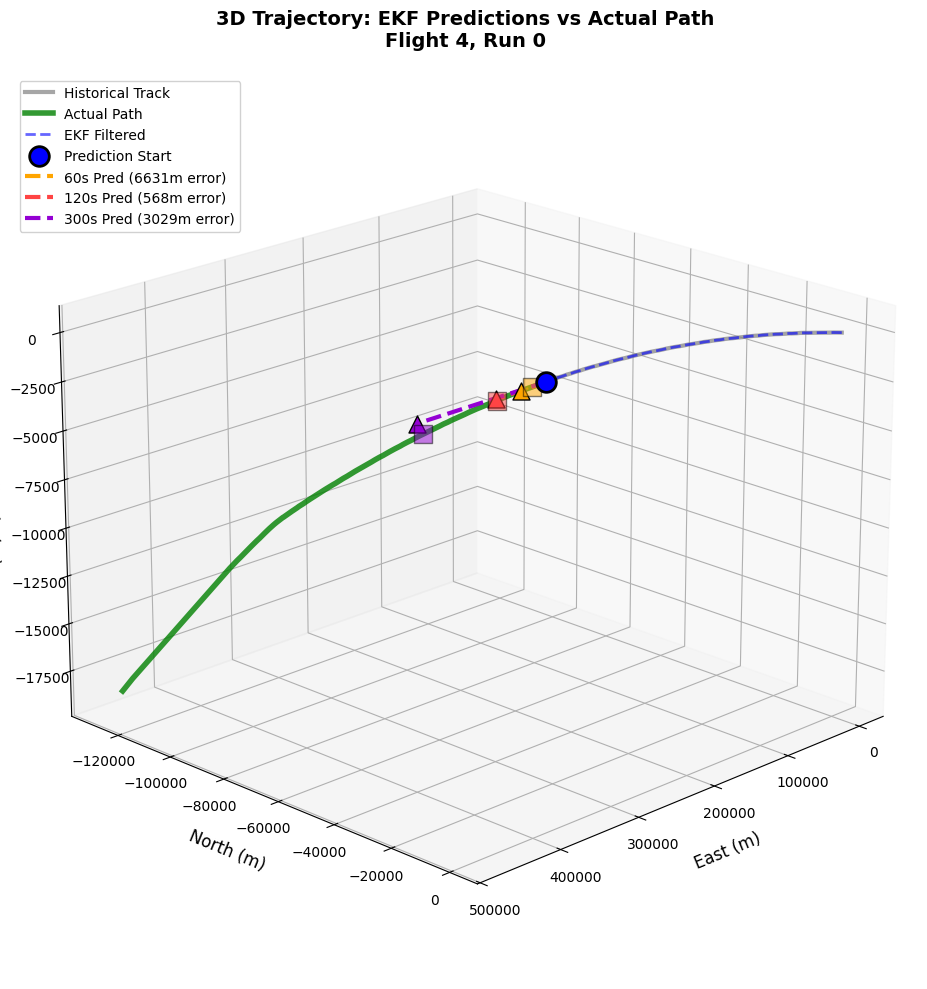

In [18]:
# Create 3D trajectory plot
fig_3d = plot_3d_trajectory(flight, filtered, predictions, errors, pred_idx)
plt.show()

# Save if needed
# fig_3d.savefig('ekf_3d_trajectory.png', dpi=150, bbox_inches='tight')

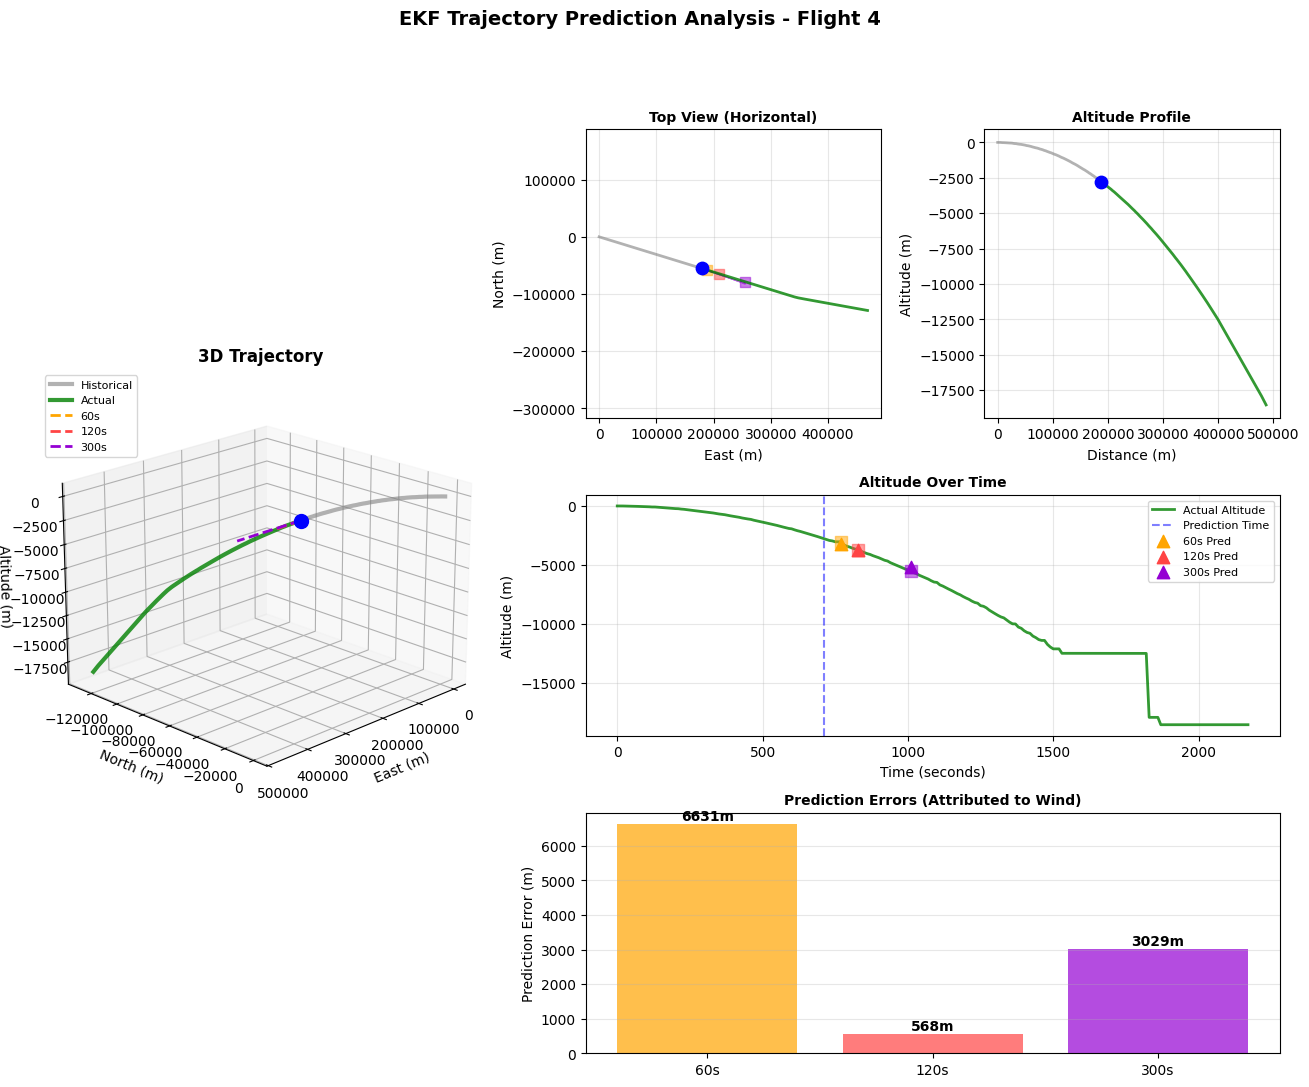

In [19]:
# Create comprehensive multi-panel plot
fig_multi = create_comprehensive_plot(flight, filtered, predictions, errors, pred_idx)
plt.show()

# Save if needed
# fig_multi.savefig('ekf_comprehensive_analysis.png', dpi=150, bbox_inches='tight')

In [20]:
# Analyze multiple flights and collect statistics
all_errors = {h: [] for h in viz.horizons}

print("Analyzing top 5 flights...")
print("-" * 40)

for i, (flight_id, run_id) in enumerate(good_flights.index[:5]):
    flight = viz.prepare_flight_data(df, flight_id, run_id)
    pred_idx = len(flight) // 3
    
    _, _, errors = viz.run_ekf_prediction(flight, pred_idx)
    
    print(f"Flight {flight_id}: ", end="")
    for h in viz.horizons:
        if h in errors:
            all_errors[h].append(errors[h]['error_m'])
            print(f"{h}s={errors[h]['error_m']:.0f}m ", end="")
    print()

# Summary statistics
print("\n" + "="*50)
print("AGGREGATE STATISTICS (5 flights):")
print("="*50)
for h in viz.horizons:
    if all_errors[h]:
        mean_err = np.mean(all_errors[h])
        std_err = np.std(all_errors[h])
        print(f"{h:3d}s horizon: {mean_err:.1f} ± {std_err:.1f} m")

Analyzing top 5 flights...
----------------------------------------
Flight 4: 60s=992m 120s=1939m 300s=4551m 
Flight 7: 60s=13181m 120s=24036m 300s=87141m 
Flight 10: 60s=304m 120s=520m 300s=2429m 
Flight 13: 60s=7988m 120s=27774m 300s=91570m 
Flight 15: 60s=1458m 120s=4411m 300s=15353m 

AGGREGATE STATISTICS (5 flights):
 60s horizon: 4784.6 ± 5025.4 m
120s horizon: 11735.9 ± 11695.8 m
300s horizon: 40208.7 ± 40391.2 m


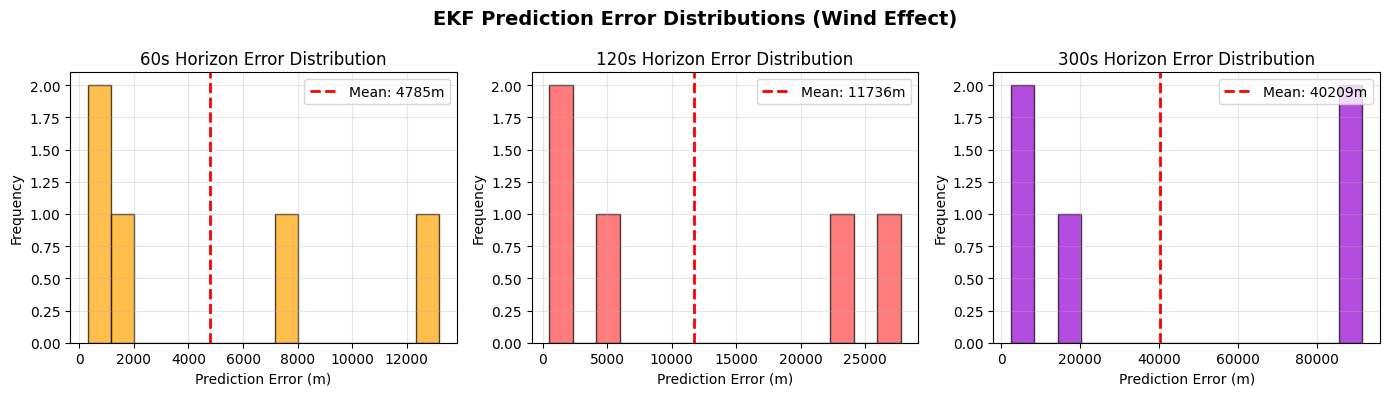

In [21]:
# Visualize error distributions across multiple flights
if all_errors[60]:  # Check if we have data
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    for idx, h in enumerate(viz.horizons):
        ax = axes[idx]
        if all_errors[h]:
            ax.hist(all_errors[h], bins=15, color=viz.colors[h], alpha=0.7, edgecolor='black')
            ax.axvline(np.mean(all_errors[h]), color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {np.mean(all_errors[h]):.0f}m')
            ax.set_xlabel('Prediction Error (m)')
            ax.set_ylabel('Frequency')
            ax.set_title(f'{h}s Horizon Error Distribution')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('EKF Prediction Error Distributions (Wind Effect)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()